## Trajectory Full Scanning
Lets show how we can recover a region of interest that is planted in a set of 10k trajectories from a Beijing taxi data set.

In [2]:
import pyscan
import matplotlib.pyplot as plt
import random
import math
import statistics
import csv
import itertools
import numpy as np

def plot_points(ax, pts, c):
    xs = []
    ys = []
    for pt in pts:
        xs.append(pt[0] )
        ys.append(pt[1])
    ax.scatter(xs, ys, color=c)

def plot_points_traj(ax, pts, c):
    xs = []
    ys = []
    for pt in pts:
        xs.append(pt[0])
        ys.append(pt[1])
    ax.plot(xs, ys, color=c)
    
def plot_approx(ax, traj_pts, core_set_pts):
    ax.set_xlim([-.01, 1.01])
    ax.set_ylim([-.01, 1.01])
    plot_points_traj(ax, traj_pts, "g")
    plot_points(ax, core_set_pts, "b")
    ax.set_axis_off()
    
def plot_full_trajectories(red, blue, ax):
    plot_set = [(reg, True) for reg in blue] + [(reg, False) for reg in red]
    random.shuffle(plot_set)
    
    for traj, is_blue in plot_set:
        if is_blue:
            plot_points_traj(ax, traj, "b")
        else:
            plot_points_traj(ax, traj, "r")   
    

def remove_long_trajectories(trajectories, percent=.9):
    def toTraj(pts):
        return pyscan.Trajectory([pyscan.Point(p[0], p[1], 1.0) for p in pts])
    
    ltraj = sorted(toTraj(traj).get_length() for traj in trajectories)
    perc_len_traj = ltraj[int(percent * len(trajectories))]
    del ltraj
    return [traj for traj in trajectories if toTraj(traj).get_length() <= perc_len_traj]


def normalize(pt, mxx, mnx, mxy, mny):
    return (pt[0] - mnx) / (mxx - mnx), (pt[1] - mny) / (mxy - mny)


def read_csv(fname, filter_long=True):
    traj_id_set = []
    with open(fname) as f:
        curr_id = None
        mnx = float("inf")
        mxx = -float("inf")
        mny = float("inf")
        mxy = -float("inf")

        for row in csv.reader(f, delimiter=" "):
            try:
                if row[0] != curr_id:
                    curr_id = row[0]
                    traj_id_set.append([])
                if math.isnan(float(row[1])) or math.isinf(float(row[1])):
                    continue
                if math.isnan(float(row[2])) or math.isinf(float(row[2])):
                    continue

                x, y = (float(row[1]), float(row[2]))
                mnx = min(mnx, x)
                mny = min(mny, y)
                mxx = max(mxx, x)
                mxy = max(mxy, y)
                traj_id_set[-1].append((float(row[1]), float(row[2])))

            except ValueError:
                continue
        norm_traces = []
        while traj_id_set:
            norm_trace = []
            trace = traj_id_set.pop()
            for pt in trace:
                norm_trace.append(normalize(pt, mxx, mnx, mxy, mny))
            norm_traces.append(norm_trace)
        if filter_long:
            return remove_long_trajectories(norm_traces)
        else:
            return norm_traces

In [3]:
# Ok we finally have the trajectories scaled to be in a [0,1]x[0,1] box with the extremely 
#long trajectories removed
trajectories = read_csv("./bjtaxi_samples_10k.tsv")

Now that we have a set of trajectories we will plant a region of interest of size between 1/50 and and 1/500 of the domain size containing roughly 5% of the trajectories where 20% will be from the blue set and 80% from the red set.

In [4]:
r = .1
p = .5
q = .2
alpha = 1 / 100
max_r = 1 / 50
n = 100
s = 4000
min_r = alpha

### Halfplane Scanning
We will start out with halfplane scanning which is the simplest and fastest method.

In [15]:
n = 400
s = 10000

red, blue, mx_plane, mx_planted = pyscan.plant_full_halfplane(trajectories, r, p, q, pyscan.DISC)
red_sample = pyscan.my_sample(red, s)
blue_sample = pyscan.my_sample(blue, s)
red_net = pyscan.my_sample(red, n)
blue_net = pyscan.my_sample(blue, n)
net = red_net + blue_net


#Sketch the trajectories down to simplify them.
m_sample = [pyscan.halfplane_kernel([pyscan.Point(pt[0], pt[1], 1.0) for pt in traj], alpha) for traj in red_sample]
b_sample = [pyscan.halfplane_kernel([pyscan.Point(pt[0], pt[1], 1.0) for pt in traj], alpha) for traj in blue_sample]
pt_net = [pyscan.halfplane_kernel([pyscan.Point(pt[0], pt[1], 1.0) for pt in traj], alpha) for traj in net]

#Now attempt to recover the region.
m_sample = list(pyscan.trajectories_to_labels(m_sample))
b_sample = list(pyscan.trajectories_to_labels(b_sample))
net_set = list(itertools.chain.from_iterable(pt_net))
reg, mx = pyscan.max_halfplane_labeled(net_set, m_sample, b_sample, pyscan.DISC)
actual_mx = pyscan.evaluate_range_trajectory(reg, 
                                             [pyscan.Trajectory([pyscan.Point(pt[0], pt[1], 1.0) for pt in traj]) for traj in red], 
                                             [pyscan.Trajectory([pyscan.Point(pt[0], pt[1], 1.0) for pt in traj]) for traj in blue], pyscan.DISC)

Planted Region: HalfSpace(pyscan::Point<2>(-1.54218, 0.53373, 1.16071)) 0.10840026221554296
Found Region: HalfSpace(pyscan::Point<2>(0.963318, -0.268361, -0.71975)) 0.11572822538248437


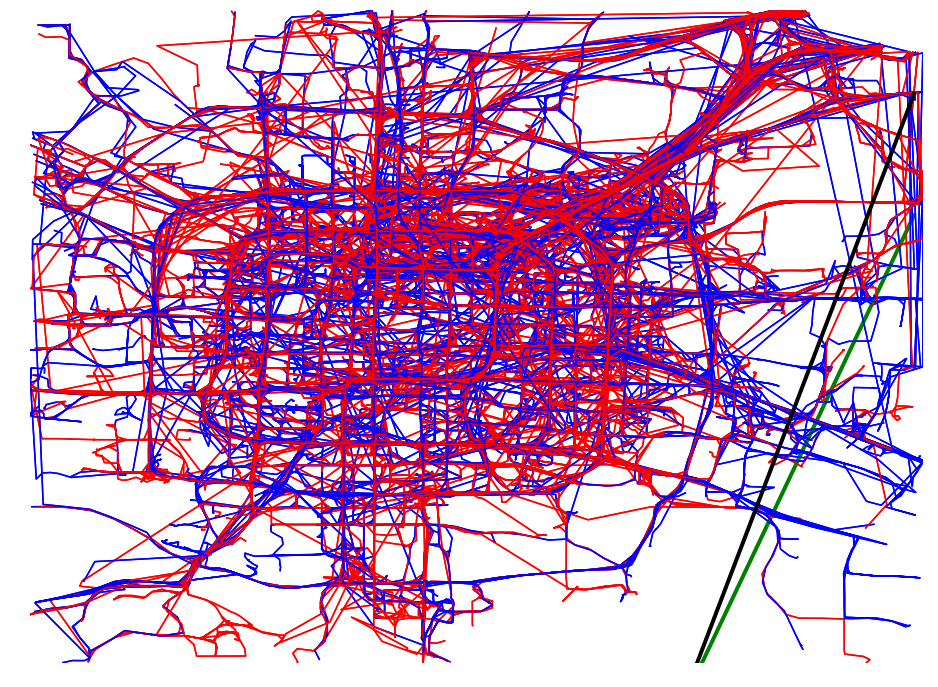

In [16]:
_, ax = plt.subplots(figsize=(16, 12))
plot_full_trajectories(red_net, blue_net, ax)

print("Planted Region: " + str(mx_plane) + " " + str(mx_planted))
print("Found Region: " + str(reg) + " " + str(actual_mx))
#Now lets plot what we got.

xs = np.arange(0, 1, .01)
ys = (-1 - mx_plane.get_coords()[0] * xs) * 1 / mx_plane.get_coords()[1]
ax.plot(xs, ys, color="g", linewidth=4)

plot_full_trajectories(red_net, blue_net, ax)

ys = (-1 - reg.get_coords()[0] * xs) * 1 / reg.get_coords()[1]
ax.plot(xs, ys, color="k", linewidth=4)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.set_axis_off()
plt.show()

The found and planted region are in the lower corner. The found region is actually more anomalous then the planted region, but also overlaps quite a lot with the planted region.

### Disk Scanning
We will first plant a disk in the domain and attempt to recover it. Plotting a subset of the data it isn't particularly clear where this region of interest is. We can use the max_disk_trajectory method to recover the region. It scans at multiple scales using multiple different coresets to minimize the number of regions that need to be considered.

In [5]:
n = 25
s = 400

trajectories = [[pyscan.Point(p[0], p[1], 1.0) for p in traj] for traj in trajectories]
while True:
    red, blue, planted_reg , planted_mx = pyscan.plant_full_disk(trajectories, r, p, q, pyscan.DISC)
    print(planted_reg.get_radius())
    if min_r < planted_reg.get_radius() < max_r:
        break

disc = pyscan.DISC

red_sample = pyscan.my_sample(red, s)
blue_sample = pyscan.my_sample(blue, s)
red_net = pyscan.my_sample(red, n)
blue_net = pyscan.my_sample(blue, n)
net = red_net + blue_net

reg, mx = pyscan.max_disk_trajectory(net, red_sample, blue_sample, min_r, max_r, alpha, disc)

0.027356629856841952
0.011568124074419107


Planted Region: Disk(pyscan::Point<2>(0.267767, 0.473677, 1), 0.0115681)
Found Region: Disk(pyscan::Point<2>(0.259012, 0.471483, 1), 0.0151749)


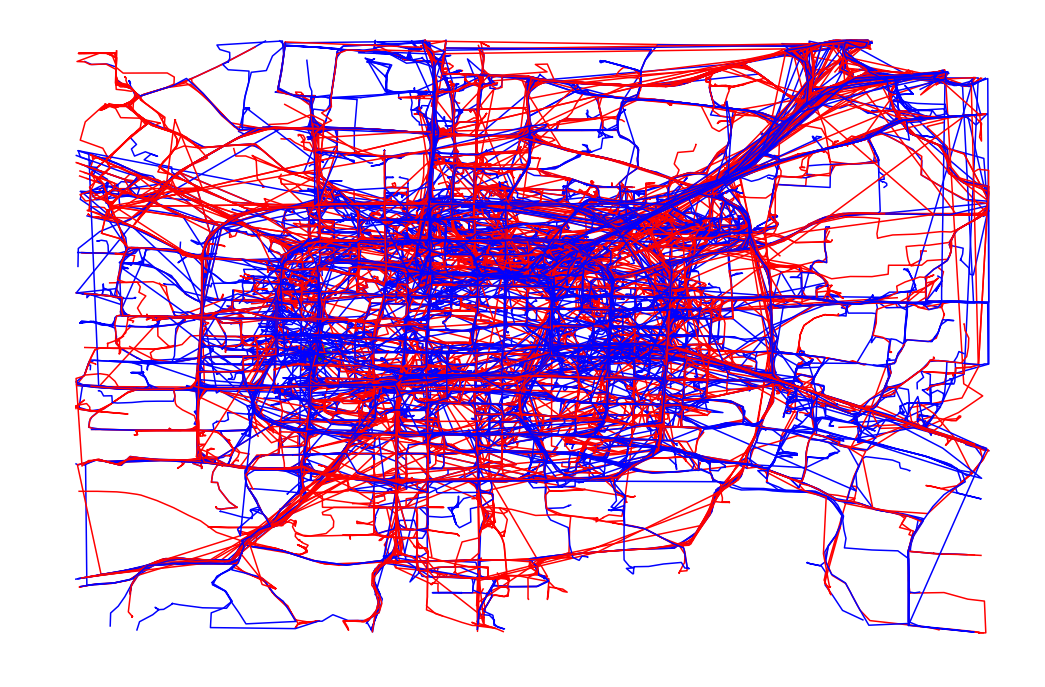

In [7]:
_, ax = plt.subplots(figsize=(18, 12))
plot_full_trajectories(red_sample, blue_sample, ax)
actor = plt.Circle((planted_reg.get_origin()[0], planted_reg.get_origin()[1]), planted_reg.get_radius(), 
                   alpha=.6,
                   color="g")
ax.add_artist(actor)

actor = plt.Circle((reg.get_origin()[0], reg.get_origin()[1]), reg.get_radius(), 
                   color="k", 
                   alpha=.6)
ax.add_artist(actor)
print("Planted Region: " + str(planted_reg))
print("Found Region: " + str(reg))
ax.set_axis_off()
plt.show()

It is hard to tell whether we actually recovered the anomaly, but we can zoom in on the region of interest to see.

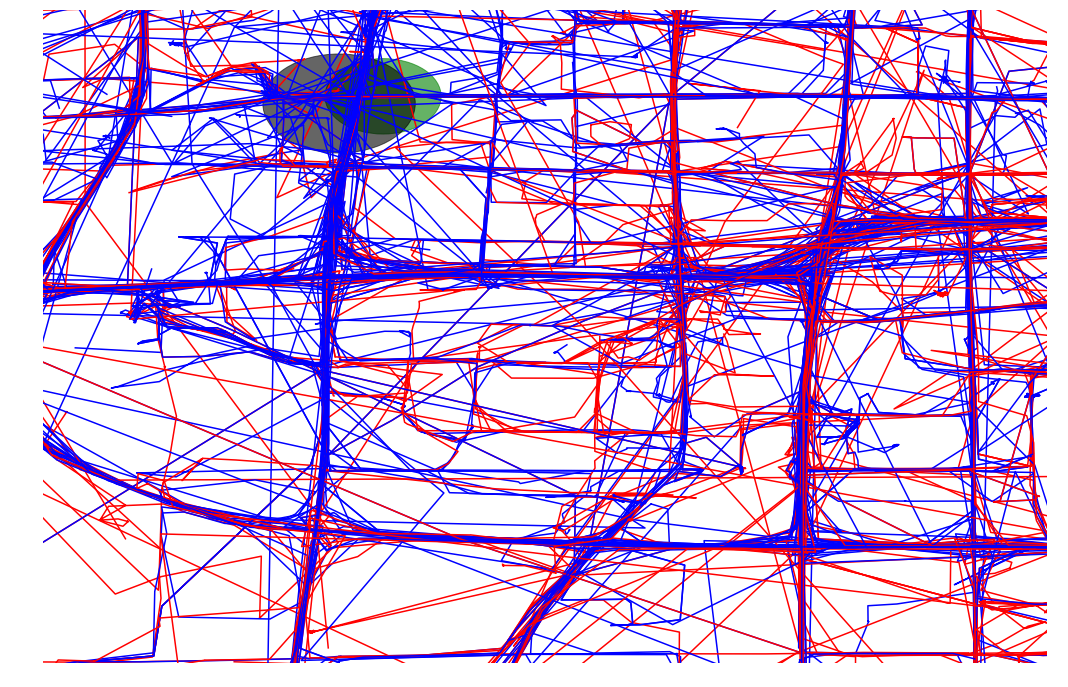

In [8]:
_, ax = plt.subplots(figsize=(18, 12))
plot_full_trajectories(red_sample, blue_sample, ax)
actor = plt.Circle((planted_reg.get_origin()[0], planted_reg.get_origin()[1]), planted_reg.get_radius(), 
                   alpha=.6,
                   color="g")
ax.add_artist(actor)

actor = plt.Circle((reg.get_origin()[0], reg.get_origin()[1]), reg.get_radius(), 
                   color="k", 
                   alpha=.6)
ax.add_artist(actor)
ax.set_xlim([.2, .4])
ax.set_ylim([.3, .5])
ax.set_axis_off()
plt.show()

### Rectangle Scanning
Again we plant a region and attempt to recover it. 

In [ ]:
while True:
    red, blue, planted_reg, _ = pyscan.plant_full_square(trajectories, r, p, q, disc)
    print
    if planted_reg.upX() - planted_reg.lowX() < max_r * 2:
        break

red_sample = pyscan.my_sample(red, s)
blue_sample = pyscan.my_sample(blue, s)
red_net = pyscan.my_sample(red, n)
blue_net = pyscan.my_sample(blue, n)
net = red_net + blue_net

m_sample = [pyscan.even_sample_error(traj, alpha, False) for traj in red_sample]
b_sample = [pyscan.even_sample_error(traj, alpha, False) for traj in blue_sample]
pt_net = [pyscan.even_sample_error(traj, alpha, False) for traj in net]
m_sample = list(pyscan.trajectories_to_labels(m_sample))
b_sample = list(pyscan.trajectories_to_labels(b_sample))
net_set = list(itertools.chain.from_iterable(pt_net))

#Ok run the algorithm.
rect, mx = pyscan.max_rect_labeled(n, 2 * max_r, m_sample, b_sample, disc)

actor = plt.Rectangle((planted_reg.upX(), planted_reg.upY()), 
                      planted_reg.upX() - planted_reg.lowX(), 
                      planted_reg.upY() - planted_reg.lowY())

actor = plt.Rectangle((rect.upX(), rect.upY()), rect.upX() - rect.lowX(), rect.upY() - rect.lowY())
ax.add_artist(actor)
